In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from pathlib import Path
import pywt

In [2]:
####################### behaviour plottings

def get_tail_angles(df_tail, heading):
    xy = df_tail.values[:, ::2] + df_tail.values[:, 1::2] * 1j
    midline = -np.exp(1j * np.deg2rad(np.asarray(heading)))
    return -np.angle(np.diff(xy, axis=1) / midline[:, None])

def load_data(h5_path, fs=200):
    df_eye = pd.read_hdf(h5_path, "eye")
    eye_angles = df_eye[[("left_eye", "angle"), ("right_eye", "angle")]].values
    df_tail = pd.read_hdf(h5_path, "tail")
    tail_angles = get_tail_angles(df_tail, df_eye["heading"].values)   

    return eye_angles, tail_angles

def low_pass_filt(x, fs, cutoff, axis=0, order=2):
    from scipy.signal import butter, filtfilt

    b, a = butter(order, cutoff / (fs / 2), btype="low")
    return filtfilt(b, a, x, axis=axis)


In [8]:
def wavelet_denoise(signal, wavelet='bior3.1', level=3, threshold_type='soft'): # pywt.wavelist(kind='discrete')
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)  # Decompose
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745  # Noise estimation (MAD)
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))  # Universal threshold
    coeffs_thresh = [pywt.threshold(c, threshold, mode=threshold_type) for c in coeffs]
    return pywt.waverec(coeffs_thresh, wavelet, mode='per')  # Reconstruct

In [15]:
import numpy as np
from scipy.ndimage import label, binary_closing, generate_binary_structure

def detect_bouts(denoised_signal, window_size=5, closing_iterations=1, 
                 min_bout_length=10, threshold_multiplier=3):
    """
    Detect increasing/decreasing bouts in a denoised signal.
    
    Parameters:
        denoised_signal (array): Denoised 1D signal
        window_size (int): Size of smoothing window for gradient
        closing_iterations (int): Number of iterations for binary closing
        min_bout_length (int): Minimum bout duration in samples
        threshold_multiplier (float): MAD multiplier for adaptive threshold
        
    Returns:
        list: List of bout dictionaries with start/end indices and type
    """
    # Compute gradient
    slope = np.gradient(denoised_signal)
    
    # Smooth gradient
    if window_size > 1:
        kernel = np.ones(window_size)/window_size
        smoothed_slope = np.convolve(slope, kernel, mode='same')
    else:
        smoothed_slope = slope
    
    # Calculate adaptive threshold using MAD
    mad = np.median(np.abs(smoothed_slope - np.median(smoothed_slope)))
    slope_threshold = threshold_multiplier * mad
    
    # Thresholding
    increasing = smoothed_slope > slope_threshold
    decreasing = smoothed_slope < -slope_threshold
    
    # Morphological closing to merge nearby regions
    struct = generate_binary_structure(1, 1)
    increasing = binary_closing(increasing, structure=struct, iterations=closing_iterations)
    decreasing = binary_closing(decreasing, structure=struct, iterations=closing_iterations)
    
    # Label regions
    inc_labels, n_inc = label(increasing)
    dec_labels, n_dec = label(decreasing)
    
    # Extract bouts from labels
    def _get_bouts(labels, n_labels):
        bouts = []
        for i in range(1, n_labels+1):
            indices = np.where(labels == i)[0]
            if len(indices) == 0:
                continue
            start = indices[0]
            end = indices[-1]
            if (end - start + 1) >= min_bout_length:
                bouts.append((start, end))
        return bouts
    
    inc_bouts = _get_bouts(inc_labels, n_inc)
    dec_bouts = _get_bouts(dec_labels, n_dec)
    
    # Combine and format results
    all_bouts = []
    for start, end in inc_bouts:
        all_bouts.append({'start': start, 'end': end, 'type': 'increasing'})
    for start, end in dec_bouts:
        all_bouts.append({'start': start, 'end': end, 'type': 'decreasing'})
    
    # Sort by start index
    all_bouts.sort(key=lambda x: x['start'])
    
    return all_bouts

In [11]:
folders = glob("F:\\swim_motion_data\\lcr_kai\\*")

# folder  = folders[4]
folder = "F:\\swim_motion_data\\lcr_kai\\2024-08-01_F2_01-T1"

profix = folder.split("\\")[-1]
save_dir = f'F:\\swim_motion_data\\lcr_kai_v2\\{profix}'
Path(save_dir).mkdir(parents=True, exist_ok=True)

date = profix.split("_")[0]
fish_no = profix.split("_")[1]
set_no = profix.split("-")[2][3:]
trial_no = profix.split("-")[-1][1:]

h5_path = f"F:\\Temp_opto\\{date}\\lcr\\TOPCAMERA\\{fish_no}\\{set_no}\\{date}_{set_no}_Trial{trial_no}.h5"

fs = 200  # target sampling frequency
eye_angles, tail_angles = load_data(h5_path, fs)
eye_angles_filt = low_pass_filt(eye_angles, fs, 2)
bout_params = {
    "n_angles_avg": 5,  # number of angles to average for tail tip angle
    "sigma": 4,  # sigma for gaussian filter
    "high": 10,  # high threshold for tail vigor
    "low": 5,  # low threshold for tail vigor
}
mean_tip_angle = tail_angles[..., -bout_params["n_angles_avg"] :].mean(-1)


#### load top cam data
top_df = pd.read_csv(f"{folder}\\TOPCAM\\y_shift_idx.csv")
y_motions = np.load(f"{folder}\\TOPCAM\\y_shift.npy")
up_idxs = top_df["ori"].values[top_df["is_up"].values == 1]
down_idxs = top_df["ori"].values[top_df["is_up"].values == -1]

#### load side cam data
side_df = pd.read_csv(f"{folder}\\SIDECAM\\x_shift_idx.csv")
x_motions = np.load(f"{folder}\\SIDECAM\\x_shift.npy")
left_idxs = side_df["ori"].values[side_df["is_left"].values == 1]
right_idxs = side_df["ori"].values[side_df["is_left"].values == -1]

#### load old episode
top_episodes = np.load(f"{folder}\\TOPCAM\\episodes_idx.npy")
side_episodes = np.load(f"{folder}\\SIDECAM\\episodes_idx.npy")

In [12]:
filt_y =  wavelet_denoise(y_motions)
filt_x =  wavelet_denoise(x_motions)

In [20]:
bouts = detect_bouts(filt_y,
                     window_size=5, # Controls gradient smoothing
                     closing_iterations=4, # Controls gap merging
                     min_bout_length=10, # Filters short fluctuations
                     threshold_multiplier=3) # Adjusts sensitivity

247


(78000.0, 78800.0)

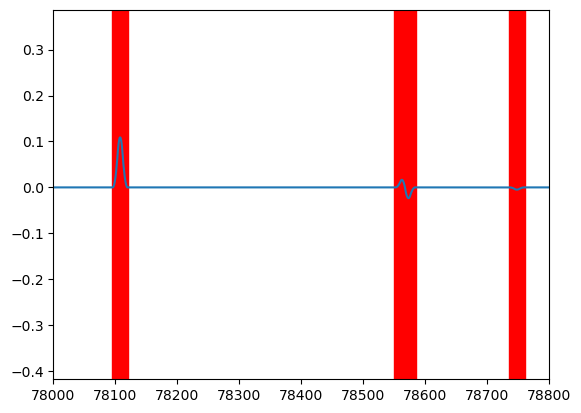

In [21]:
xlim = np.array([390, 394])
print(len(bouts))
plt.plot(filt_y)
for bout in bouts:
    plt.axvspan(bout["start"], bout["end"], color='r')
plt.xlim(xlim*200)